In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import optuna
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBRegressor

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer


import warnings
warnings.filterwarnings('ignore')

In [2]:
STATE = 1999
VAL_SIZE = 0.2
TARGET_COL = '23SoilWC ค.ชื้นดิน'

train_path = Path('/kaggle/input/farm-connect-soil-water-content-prediction/train/train')
test_path = Path('/kaggle/input/farm-connect-soil-water-content-prediction/test/test')

train_list = []
test_list = []
for file in sorted(list(train_path.rglob('*.csv'))):
    train_list.append(pd.read_csv(file))
train_df = pd.concat(train_list)

for file in sorted(list(test_path.rglob('*.csv'))):
    test_list.append(pd.read_csv(file))
test_df = pd.concat(test_list)

print(train_df.shape)
train_df.head()

(1111, 19)


,index,time,1Air Humidity,1AirTemperature,1LightHigh,1LightLow,11Rain Accumulate (mm),11Rain count,12WindSpeed,13WindDirection,23SoilWC ค.ชื้นดิน,23SoilTemp.อุณหภูมิดิน,23SoilEC,23SoilpH,26N,26P,26K,29SoilTension,flow1
0,01_1,01:00:50.174233+00,97.3,21.8,0.0,9.57,0.0,0.0,0.0,6.0,31.4,23.6,0.11,8.3,21.0,95.0,87.0,23.0,0.0
1,01_2,01:02:51.384714+00,96.6,22.0,0.0,9.81,0.0,0.0,0.0,6.0,31.9,23.6,0.11,8.3,21.0,95.0,87.0,22.0,0.0
2,01_3,01:04:52.127056+00,95.9,22.2,0.0,10.22,0.0,0.0,0.0,5.0,32.4,23.6,0.11,8.3,21.0,95.0,87.0,NaN,0.0
3,01_4,01:06:50.205974+00,95.3,22.4,0.0,10.25,0.0,0.0,0.0,6.0,32.4,23.6,0.11,8.3,21.0,95.0,87.0,22.0,0.0
4,01_5,01:08:50.162332+00,93.8,22.4,0.0,10.45,0.0,0.0,0.0,6.0,31.7,23.6,0.11,8.3,21.0,95.0,87.0,23.0,0.0


In [3]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 4 * IQR
    upper_bound = Q3 + 4 * IQR
    return df[((df[column] >= lower_bound) & (df[column] <= upper_bound)) | (df[column].isna())]

# Apply the function to each column
filtered_df = train_df.copy()
for column in train_df.columns:
    if column in [TARGET_COL, 'index', 'time']:
        print(f'Skipping {column}')
        continue
    filtered_df = remove_outliers(filtered_df, column)

# Compare shapes
original_shape = train_df.shape
filtered_shape = filtered_df.shape

print(original_shape, filtered_shape)

train_df = filtered_df

Skipping index
Skipping time
Skipping 23SoilWC ค.ชื้นดิน
(1111, 19) (843, 19)


<Axes: >

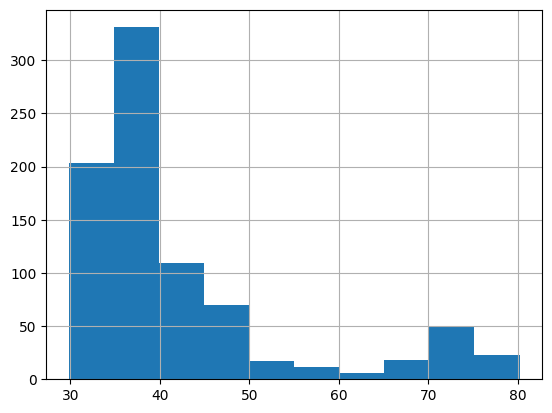

In [4]:
X_train = train_df.copy()
# Drop rows with missing targets
X_train = X_train[X_train[TARGET_COL].notna()]

y_train = X_train.pop(TARGET_COL)

y_train.hist()

Check missing

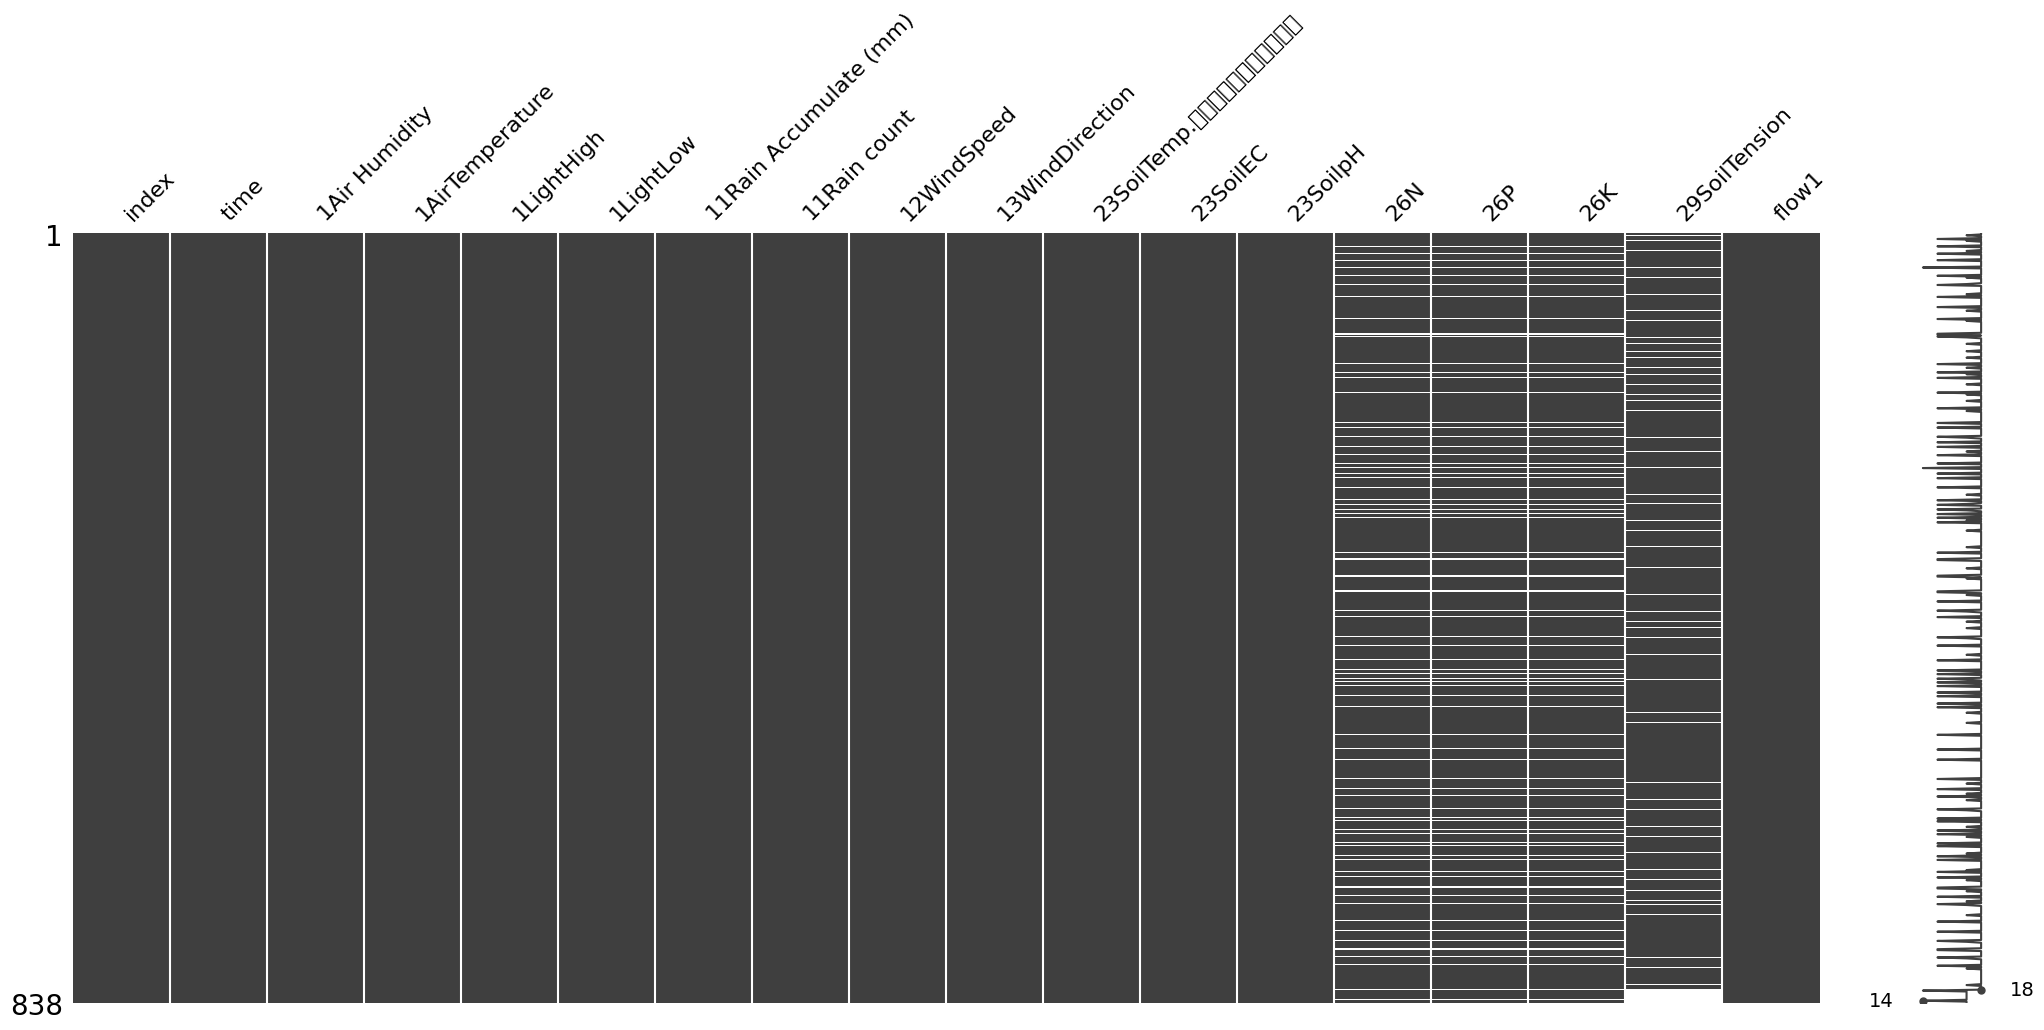

In [5]:
msno.matrix(X_train)
plt.show()

In [6]:
def clean_df(df: pd.DataFrame) -> pd.DataFrame:
    
    # Drop unnecessary columns
    df = df[df.columns[~df.columns.isin(['index', 'time'])]]
    
    return df
    
    
X_train = clean_df(X_train)
X_test = clean_df(test_df)

In [7]:
# Define the iterative imputer
# iterative_imputer = IterativeImputer(max_iter=30, random_state=STATE)


# Define the KNN imputer, specifying the number of neighbors
knn_imputer = KNNImputer(n_neighbors=5)

# Columns to impute
columns_to_impute = ['1Air Humidity', '1AirTemperature', '1LightHigh', '1LightLow', '11Rain Accumulate (mm)', '11Rain count', '26N', '26P', '26K', '29SoilTension']

# Apply imputation to the training data
X_train_imputed = X_train.copy()
X_train_imputed[columns_to_impute] = knn_imputer.fit_transform(X_train[columns_to_impute])

# Apply the same imputation to the test data (using the same model as the training data)
X_test_imputed = X_test.copy()
X_test_imputed[columns_to_impute] = knn_imputer.transform(X_test[columns_to_impute])

# Check if the imputation was successful by counting missing values in both datasets again
missing_values_train_imputed = X_train_imputed.isnull().sum()
missing_values_test_imputed = X_test_imputed.isnull().sum()

assert 0 == missing_values_train_imputed.sum() == missing_values_test_imputed.sum()


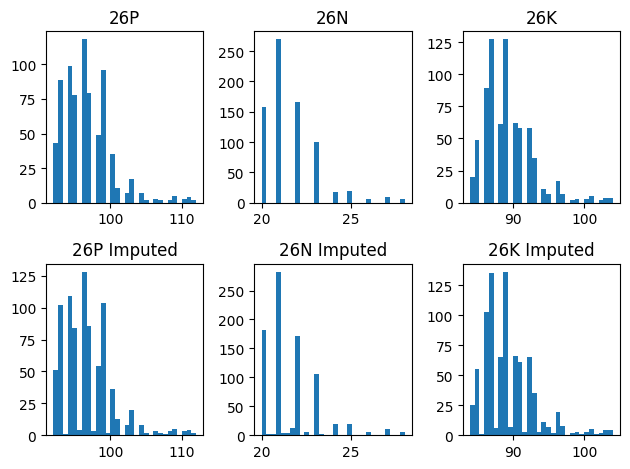

In [8]:
fig, axs = plt.subplots(2,3)

axs[0,0].set_title('26P')
axs[0,0].hist(train_df['26P'], bins=30)
axs[1,0].set_title('26P Imputed')
axs[1,0].hist(X_train_imputed['26P'], bins=30)
axs[0,1].set_title('26N')
axs[0,1].hist(train_df['26N'], bins=30)
axs[1,1].set_title('26N Imputed')
axs[1,1].hist(X_train_imputed['26N'], bins=30)
axs[0,2].set_title('26K')
axs[0,2].hist(train_df['26K'], bins=30)
axs[1,2].set_title('26K Imputed')
axs[1,2].hist(X_train_imputed['26K'], bins=30)
plt.tight_layout()
plt.show()

In [9]:
# Hyperparameter tuning for one dataset
def objective(trial):
    
    _X_train, _X_valid, _y_train, _y_valid = train_test_split(X_train_imputed, y_train, random_state=STATE, test_size=VAL_SIZE)
    
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 3000, step=100),
        "max_depth":trial.suggest_int("max_depth", 1, 4),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        "gamma": trial.suggest_float("gamma", 0.2, 1.0, step=0.2),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 7),
        "subsample": trial.suggest_float("subsample", 0.4, 0.8),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-6, 100.),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-6, 100.),
        
    }
    
    model = XGBRegressor(
        **params,
        early_stopping_rounds=300,
#         n_jobs=-1, 
#         tree_method='gpu_hist', 
#         gpu_id=0
    )
    
    model.fit(_X_train, _y_train,
              eval_set=[(_X_valid, _y_valid)],
              verbose=0)
    
    y_hat = model.predict(_X_valid)
    
    return mean_absolute_error(_y_valid, y_hat)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)
chosen_model = XGBRegressor(**study.best_params)

[I 2024-02-24 19:00:05,243] A new study created in memory with name: no-name-e147919c-f8af-4c81-8005-456fb0d54901
[I 2024-02-24 19:00:06,889] Trial 0 finished with value: 1.9218079135531472 and parameters: {'n_estimators': 2800, 'max_depth': 2, 'learning_rate': 0.010887975051315711, 'gamma': 0.2, 'min_child_weight': 1, 'subsample': 0.7316647619425674, 'colsample_bytree': 0.7152487513383468, 'reg_alpha': 53.03380734483724, 'reg_lambda': 93.91815453523691}. Best is trial 0 with value: 1.9218079135531472.
[I 2024-02-24 19:00:07,535] Trial 1 finished with value: 8.215502738952637 and parameters: {'n_estimators': 900, 'max_depth': 4, 'learning_rate': 0.00041835863923359615, 'gamma': 1.0, 'min_child_weight': 4, 'subsample': 0.5276000282948549, 'colsample_bytree': 0.34626944119109093, 'reg_alpha': 55.09886888749426, 'reg_lambda': 27.310417882047798}. Best is trial 0 with value: 1.9218079135531472.
[I 2024-02-24 19:00:07,989] Trial 2 finished with value: 9.169319684164865 and parameters: {'n_e

In [10]:
study.best_params

{'n_estimators': 900,
 'max_depth': 3,
 'learning_rate': 0.04140217029369335,
 'gamma': 1.0,
 'min_child_weight': 2,
 'subsample': 0.6997846309053446,
 'colsample_bytree': 0.8587988353194344,
 'reg_alpha': 2.2087529147797866,
 'reg_lambda': 10.135057501967538}

In [11]:
chosen_model.fit(X_train, y_train)

preds = chosen_model.predict(clean_df(test_df))

preds

array([35.055195, 35.214546, 34.61743 , 35.57375 , 35.80064 , 35.08136 ,
       34.565937, 35.486767, 35.102383, 34.997112, 34.79048 , 34.842323,
       35.401783, 36.081795, 35.14405 , 35.426746, 36.52914 , 46.873325,
       48.218204, 50.76303 , 51.99157 , 53.261517, 53.234055, 52.793766,
       52.494843, 54.33531 , 53.375526, 53.10265 , 52.925552, 49.521053,
       52.77559 , 47.24613 , 67.490685, 73.29666 , 67.18916 , 67.40808 ,
       68.146194, 68.896286, 70.03086 , 69.46887 , 64.64628 , 69.09006 ,
       68.14722 , 69.268005, 69.38564 , 68.6458  , 69.05268 , 69.917305,
       63.185963, 64.54855 , 66.85559 , 66.637695, 64.864395, 50.238823,
       51.46829 , 50.486294, 49.990753, 51.46262 , 50.162804, 50.899773,
       44.99326 , 50.269535, 36.617035, 41.7674  , 40.49196 , 37.440277,
       41.435028, 40.757713, 39.07547 , 40.213917, 39.328598, 39.750256,
       40.80429 , 41.207863, 41.615112, 40.91548 , 39.52054 , 37.372673,
       39.98546 , 39.536198, 38.427483, 37.907494, 

In [12]:
sub = pd.read_csv('/kaggle/input/farm-connect-soil-water-content-prediction/sample_submission.csv')
sub[TARGET_COL].iloc[1:] = preds[1:]
sub.to_csv('submission.csv', index=False)

In [13]:
sub

,index,23SoilWC ค.ชื้นดิน
0,02_1,31.100000
1,02_2,35.214546
2,02_3,34.617432
3,02_4,35.573750
4,02_5,35.800640
...,...,...
224,09_112,48.649361
225,09_113,42.740578
226,09_114,47.547573
227,09_115,47.547573
